### Using a TRILEGAL file for a given healpix, 
### produce maps with Mr - [Fe/H] priors 

Version with a subsample of the hipscat TRILEGAL catalog processed with LSDB

In [1]:
try:
    client.shutdown()
    client.close()

except Exception as e:
    print(e)
    pass

name 'client' is not defined


In [2]:
%matplotlib inline
import sys
import healpy as hp
import hipscat
import hipscat_import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dask.distributed import Client

pd.set_option('display.max_columns', None)

In [3]:
n = 1
mem = str(16*n)+"GB"
print("workers=", str(96//n), "\nmem=", mem)

try:
    client.shutdown()
    client.close()

    client = Client(n_workers=96//n, threads_per_worker=1, memory_limit=mem, 
                dashboard_address=':41987')
except Exception as e: 
    print("Exception raised", e)
    client = Client(n_workers=96//n, threads_per_worker=1, memory_limit=mem, 
                dashboard_address=':41987')

client

workers= 96 
mem= 16GB
Exception raised name 'client' is not defined


/nvme/lovro/miniconda3/envs/photoD-dev/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 41987 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40639 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40639/status,
Dashboard: http://127.0.0.1:40639/status,Workers: 96
Total threads: 96,Total memory: 1.40 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35179,Workers: 96
Dashboard: http://127.0.0.1:40639/status,Total threads: 96
Started: Just now,Total memory: 1.40 TiB
Comm: tcp://127.0.0.1:46121,Total threads: 1
Dashboard: http://127.0.0.1:37531/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:36581,


## LSDB

CPU times: user 1.56 s, sys: 1.05 s, total: 2.61 s
Wall time: 5.5 s


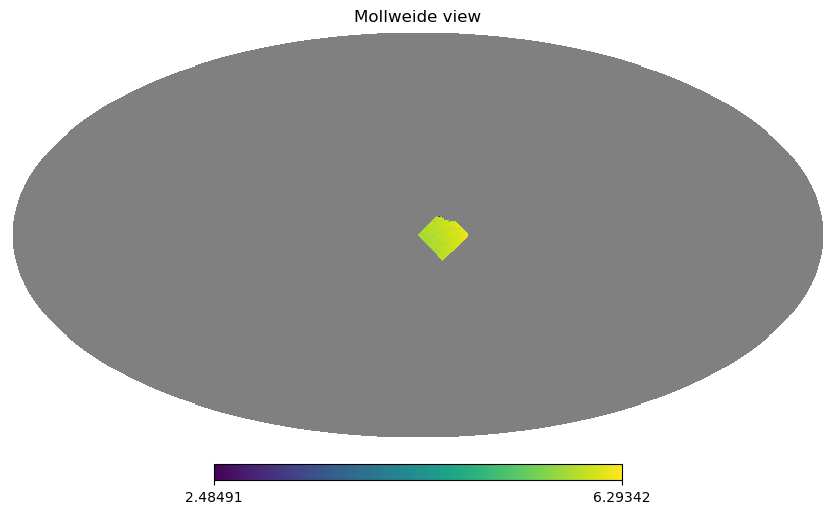

In [4]:
%%time
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch, box_search

tril_fn = "/home/lovro/scratch/data/TRILEGAL_hipscat_new_2/trilegal/"
#tril_fn = "/home/lovro/scratch/data/TRILEGAL_hipscat_small_chunks/trilegal/"

# tril = lsdb.read_hipscat(tril_fn, search_filter=BoxSearch(ra=(-160, 160), dec=(-21, -20)))
# tril = lsdb.read_hipscat(tril_fn, search_filter=BoxSearch(ra=(-20, 20), dec=(-21, -20)))
# tril = lsdb.read_hipscat(tril_fn, search_filter=BoxSearch(ra=(-120, 120), dec=(-1.26, +1.26)))
tril = lsdb.read_hipscat(tril_fn, search_filter=BoxSearch(ra=(340, 350), dec=(-1.26, +1.26)))
# tril = lsdb.read_hipscat(tril_fn, search_filter=BoxSearch(ra=(-120., -100.), dec=(-0.26, +0.26)))
tril.skymap(lambda df, a: np.log(len(df)+1), order=9)

CPU times: user 4.1 s, sys: 1.53 s, total: 5.63 s
Wall time: 8.59 s


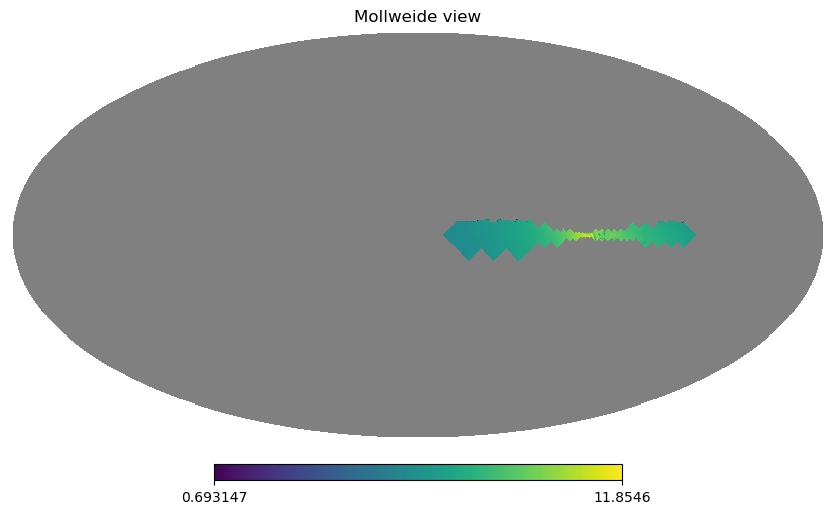

In [6]:
%%time
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch, box_search

# tril_fn = "/home/lovro/scratch/data/TRILEGAL_hipscat_new_2/trilegal/"
tril_fn = "/home/lovro/scratch/data/TRILEGAL_hipscat_small_chunks/trilegal/"
# tril = lsdb.read_hipscat(tril_fn, search_filter=BoxSearch(ra=(-160, 160), dec=(-21, -20)))
# tril = lsdb.read_hipscat(tril_fn, search_filter=BoxSearch(ra=(-20, 20), dec=(-21, -20)))
# tril = lsdb.read_hipscat(tril_fn, search_filter=BoxSearch(ra=(-120, 120), dec=(-1.26, +1.26)))
tril = lsdb.read_hipscat(tril_fn, search_filter=BoxSearch(ra=(-120., -20.), dec=(-0.26, +0.26)))
tril.skymap(lambda df, a: np.log(len(df)+1), order=9)

In [7]:
cat

ValueError: filedescriptor out of range in select()

In [5]:
tril

,ra,dec,gall,galb,m_ini,logage,m_h,mu0,av,mratio,mass,logl,logte,logg,umag,gmag,rmag,imag,zmag,ymag,ring256,gc,label,Norder,Dir,Npix
npartitions=4,,,,,,,,,,,,,,,,,,,,,,,,,,
5260204364768739328,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int16,int16,uint8,uint64,uint64
5278218763278221312,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5296233161787703296,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5314247560297185280,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
sys.path.append('../src')
import LocusTools as lt
import BayesTools as bt
import PlotTools as pt

def process(df, pix):
    sys.path.append('../src')
    import LocusTools as lt
    # import BayesTools as bt
    import PlotTools as pt
    import importlib
    importlib.reload(lt)
    # importlib.reload(bt)
    importlib.reload(pt)

    # rootname = '/mnt/beegfs/scratch/lovro/temp/hipscat_LSDB_sample'  # TODO: clean this up!
    df=df.rename(columns={"gall": "glon", "galb": "glat", "gc": "comp", 
                          "m_h": "FeH", "av": "Av", "mu0": "DM"}) 
                          # 'gc': 'GC',
                          # "label": "pop"})
    cat = lt.readTRILEGALLSDB(df)
    cat['Mr'] = cat['rmag'] - cat['Ar'] - cat['DM']

    # save original TRILEGAL magnitudes
    for b in ['u', 'g', 'r', 'i', 'z']:  
        cat[b+'magTL'] = cat[b+'mag']
    ## and this is a hack to "fix" TRILEGAL [Fe/H] distribution to be more similar to SDSS measurements
    if (1):
        # shift thin disk stars to lower [Fe/H] by 0.3 dex
        # cat['FeH'] = np.where(cat['GC']==1, cat['FeH']-0.3, cat['FeH'])
        cat['FeH'] = np.where(cat['comp']==1, cat['FeH']-0.3, cat['FeH'])
        # shift halo stars to higher [Fe/H] by 0.1 dex
        # cat['FeH'] = np.where(cat['GC']==3, cat['FeH']+0.1, cat['FeH'])    
        cat['FeH'] = np.where(cat['comp']==3, cat['FeH']+0.1, cat['FeH'])    

    
    ## separate MS/RGs from white dwarfs 
    # catMSRG = cat[cat['pop']<9]
    # catWD = cat[cat['pop']==9]
    # catMSRG = cat[cat['label']<9]
    # catWD = cat[cat['label']==9]
    # print('MSRG:', np.size(catMSRG), 'WD:', np.size(catWD))
    
    # return pd.DataFrame(data=[(len(trilegal), type(trilegal))], columns=['len', 'dtype']) # <--- it is expected that a Pandas is returned
    # return pd.DataFrame(data=[(pix, len(cat))], columns=['HealPix', 'len']) #, columns=['partition']) # <--- it is expected that a Pandas is returned
    # return pd.DataFrame(data=[()], columns=['HealPix', 'len']) #, columns=['partition']) # <--- it is expected that a Pandas is returned
    return cat

In [6]:
%%time
cat = tril.map_partitions(process, include_pixel=True)

CPU times: user 7.8 ms, sys: 7.71 ms, total: 15.5 ms
Wall time: 12.6 ms


In [30]:
cat.compute()

,glon,glat,comp,logage,FeH,DM,Av,logg,gmag,rmag,imag,umag,zmag,label,Ar,ug,gr,ri,iz,gi,Mr,umagTL,gmagTL,rmagTL,imagTL,zmagTL
_hipscat_index,,,,,,,,,,,,,,,,,,,,,,,,,,
5260204364907151360,65.981688,-61.280436,3,10.11,-2.09,18.100000,0.139,5.047,28.312000,27.377001,26.962999,30.216999,26.757999,1,0.123306,1.854443,0.885677,0.384285,0.180585,1.269961,9.153694,30.216999,28.312000,27.377001,26.962999,26.757999
5260204371076972544,65.994389,-61.280453,3,10.11,-2.00,18.299999,0.136,4.214,22.729000,22.480000,22.403000,23.535999,22.392000,1,0.120645,0.757535,0.200742,0.047924,-0.012888,0.248667,4.059355,23.535999,22.729000,22.480000,22.403000,22.392000
5260204378026934272,65.991841,-61.277805,3,10.11,-1.52,16.350000,0.117,4.632,22.754999,22.296000,22.118000,23.746000,22.051001,1,0.103790,0.948447,0.417484,0.152986,0.046449,0.570470,5.842209,23.746000,22.754999,22.296000,22.118000,22.051001
5260204387489284096,66.007496,-61.281961,3,10.11,-2.09,18.150000,0.144,5.021,28.049000,27.146999,26.747999,29.889000,26.551001,1,0.127742,1.787626,0.850904,0.368214,0.171706,1.219118,8.869257,29.889000,28.049000,27.146999,26.747999,26.551001
5260204392514060288,66.003342,-61.277799,3,10.07,-1.52,15.450000,0.121,4.704,22.511999,21.951000,21.723000,23.705999,21.625999,1,0.107339,1.149991,0.518063,0.202132,0.075747,0.720195,6.393662,23.705999,22.511999,21.951000,21.723000,21.625999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5329482602942300160,85.531913,-49.147784,3,10.11,-2.09,18.100000,0.283,4.960,27.375999,26.518000,26.132000,29.087999,25.934999,1,0.251048,1.609070,0.757580,0.325497,0.147293,1.083077,8.166950,29.087999,27.375999,26.518000,26.132000,25.934999
5329482608499752960,85.530379,-49.146493,3,10.11,-1.20,16.500000,0.302,5.017,27.916000,26.570999,25.962999,30.513000,25.652000,1,0.267903,2.487160,1.237840,0.543435,0.257954,1.781275,9.803097,30.513000,27.916000,26.570999,25.962999,25.652000
5329482944547389440,85.505935,-49.137768,3,10.07,-1.32,16.100000,0.172,4.973,26.750000,25.528000,24.990000,29.155001,24.712999,1,0.152581,2.342443,1.160968,0.501228,0.246789,1.662196,9.275419,29.155001,26.750000,25.528000,24.990000,24.712999


In [7]:
%%time
## separate MS/RGs from white dwarfs 
catMSRG = cat[cat['label']<9]

CPU times: user 1.42 ms, sys: 0 ns, total: 1.42 ms
Wall time: 1.41 ms


In [8]:
## separate MS/RGs from white dwarfs 
catWD = cat[cat['label']==9]
print('MSRG:', np.size(catMSRG), 'WD:', np.size(catWD))

MSRG: 1 WD: 1


## a few more sanity plots and a comparison to SDSS locus parametrization (MS & RG)

In [9]:
# augmented SDSS locus for DSED 10 Gyr isochrone
datafile = '../data/LocusData/SDSSDSEDlocus_10Gyr.txt'
L10 = lt.readSDSSDSEDlocus(datafile, fixForStripe82=False)
# white dwarfs
infile = '../data/LocusData/WD_Hydrogen_MrColorSequences.txt'
HWD = lt.readWDlocus(infile)
infile = '../data/LocusData/WD_Helium_MrColorSequences.txt'
HeWD = lt.readWDlocus(infile)

(7.0, -4.0)

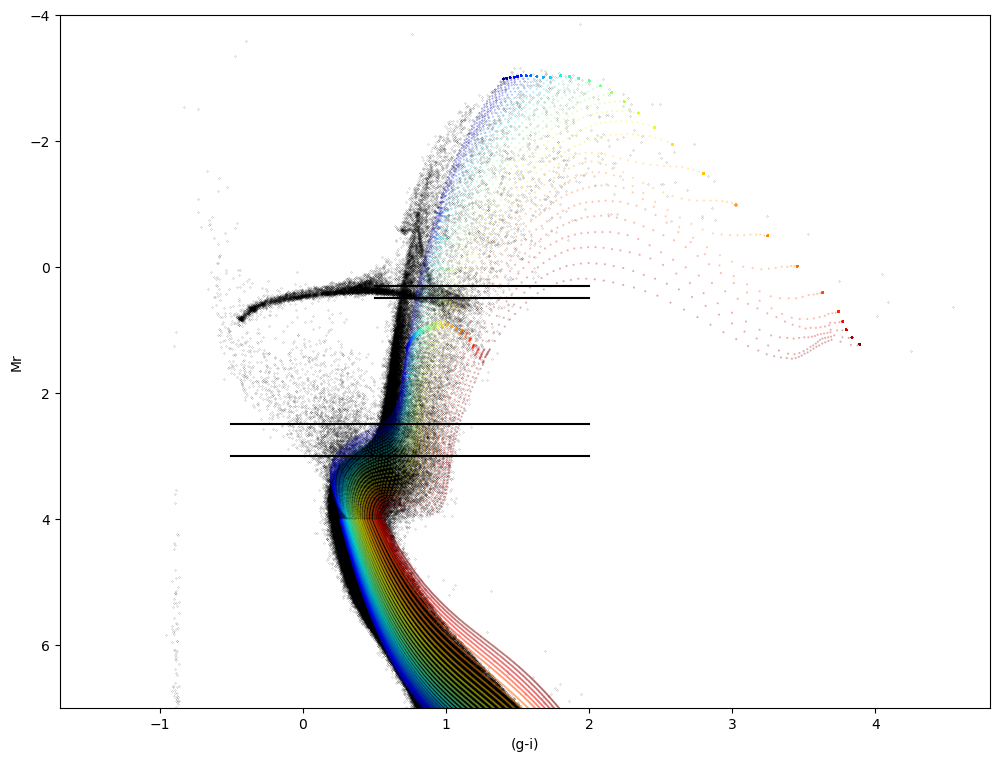

In [10]:
# compare selected stars to the full sample
fig,ax = plt.subplots(1,1,figsize=(12,9))

ax.set_xlim(-1.7,4.8)
ax.set_ylim(18,-4) 
ax.set_xlabel('(g-i)')
ax.set_ylabel('Mr')

ax.scatter(cat['gi'], cat['Mr'], s=0.01, c='black')  
 
ax.scatter(L10['gi'], L10['Mr'], s=0.3, c=L10['FeH'], cmap=plt.cm.jet, alpha=0.3)

ax.plot(HWD['gi'], HWD['Mr'], 'r')
ax.plot(HeWD['gi'], HeWD['Mr'], 'b')


ax.plot([0.5, 2.0], [0.3,0.3], c='black')
ax.plot([0.5, 2.0], [0.5,0.5], c='black')

ax.plot([-0.5, 2.0], [3.0, 3.0], c='black')
ax.plot([-0.5, 2.0], [2.5,2.5], c='black')

ax.set_xlim(-1.7,4.8)
ax.set_ylim(7,-4) 


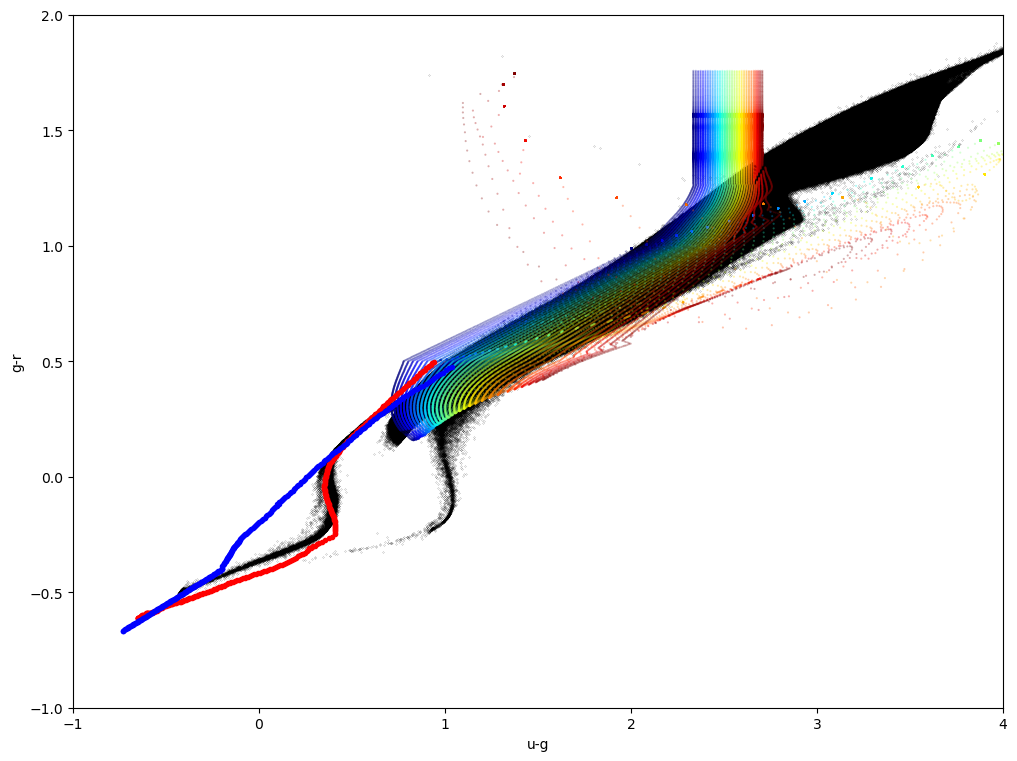

In [11]:
# compare selected stars to the full sample
fig,ax = plt.subplots(1,1,figsize=(12,9))

ax.set_xlim(-1.0,4.0)
ax.set_ylim(-1,2.0) 
ax.set_xlabel('u-g')
ax.set_ylabel('g-r')

ax.scatter(cat['ug'], cat['gr'], s=0.01, c='black')  
 
ax.scatter(L10['ug'], L10['gr'], s=0.3, c=L10['FeH'], cmap=plt.cm.jet, alpha=0.3)

ax.plot(HWD['ug'], HWD['gr'], '.-r')
ax.plot(HeWD['ug'], HeWD['gr'], '.-b')

## Generate simulated "observed" photometry with uncertainties:
### - original magnitudes  from TRILEGAL have suffix "TL" (umagTL, ugTL...)
### - re-generated mags and colors using SDSS stellar locus, and without noise, have suffix "SL" 
### - "observed" versions will have suffix Obs (including re-generated errors, see 6 below)

In [12]:
### all good so far, now: 
## 1) given rmag, Ar and DM, generate Mr 
## 2) with FeH and Mr, generate colors 
## 3) with original r magnitude, generate other magnitudes from colors
## 4) given magnitudes, generate errors for LSST
## 5) generate observed mags
## 6) regenerate "observed" errors from "observed" magnitudes
## 7) store in a data file 

In [16]:
## 1) already done above

In [ ]:
print(np.min(catMSRG['Mr']).compute(), np.max(catMSRG['Mr']).compute())
print(np.min(catMSRG['FeH']).compute(), np.max(catMSRG['FeH']).compute())

In [ ]:
print(np.min(catMSRG['Mr']), np.max(catMSRG['Mr']))
print(np.min(catMSRG['FeH']), np.max(catMSRG['FeH']))

In [13]:
## 2) actual call to get colors (5ms with fast version)
# limit FeH and Mr to values supported by LSSTlocus (DSED version)
FeHmin = -2.50
FeHmax = 0.50
MrRGcut = -2.0  # limit from TRILEGAL priors 
MrMax = 16.0    # limit from SDSS locus 
# apply FeH and Mr cuts above: 
tGoodMSRG = catMSRG[(catMSRG['FeH']>=FeHmin)&(catMSRG['FeH']<=FeHmax)&(catMSRG['Mr']>MrRGcut)&(catMSRG['Mr']<MrMax)] #.compute()
print(np.size(tGoodMSRG), np.size(tGoodMSRG)/np.size(catMSRG)) 

1 1.0


In [18]:
## 2) actual call to get colors (5ms with fast version)
# limit FeH and Mr to values supported by LSSTlocus (DSED version)
FeHmin = -2.50
FeHmax = 0.50
MrRGcut = -2.0  # limit from TRILEGAL priors 
MrMax = 16.0    # limit from SDSS locus 
# apply FeH and Mr cuts above: 
tGoodMSRG = catMSRG[(catMSRG['FeH']>=FeHmin)&(catMSRG['FeH']<=FeHmax)&(catMSRG['Mr']>MrRGcut)&(catMSRG['Mr']<MrMax)]
print(np.size(tGoodMSRG), np.size(tGoodMSRG)/np.size(catMSRG)) 

1 1.0


In [14]:
print(np.min(tGoodMSRG['Mr']), np.max(tGoodMSRG['Mr']))
print(np.min(tGoodMSRG['FeH']), np.max(tGoodMSRG['FeH']))

dd.Scalar<series-..., dtype=float32> dd.Scalar<series-..., dtype=float32>
dd.Scalar<series-..., dtype=float32> dd.Scalar<series-..., dtype=float32>


In [32]:
%%time
# ## assign colors to MSRG subsample
# timeStart = !date +%s  
# ## actual call to get (dust-free) colors for each star in tGoodOK (5ms with fast version)
# lt.getColorsFromMrFeHDSED(L10, tGoodMSRG)
# timeEnd = !date +%s  
# runTime = int(timeEnd[0])-int(timeStart[0])
# print('Finished in', runTime, 'seconds.')

sys.path.append('../src')
import LocusTools as lt
import PlotTools as pt
import importlib
importlib.reload(lt)
importlib.reload(pt)

def func2(df): #, pix):
    
    sys.path.append('../src')
    import LocusTools as lt
    import PlotTools as pt
    import importlib
    importlib.reload(lt)
    importlib.reload(pt)
    
    return lt.getColorsFromMrFeHDSED(L10[['Mr', 'FeH', 'ug', 'gr', 'ri', 'iz', 'gi']], df[['Mr', 'FeH', 'ug', 'gr', 'ri', 'iz']])
    # return lt.getColorsFromMrFeHDSED(L10[::100], df.sample(frac=0.2))

# tGoodMSRG = catMSRG[(catMSRG['FeH']>=FeHmin)&(catMSRG['FeH']<=FeHmax)&(catMSRG['Mr']>MrRGcut)&(catMSRG['Mr']<MrMax)]

tGoodMSRG_assigned_colors = tGoodMSRG.map_partitions(func2) #, include_pixel=True).compute()

CPU times: user 26.5 ms, sys: 7.39 ms, total: 33.9 ms
Wall time: 28.6 ms


In [33]:
%time temp = tGoodMSRG_assigned_colors.compute()

/mnt/beegfs/scratch/lovro/photod-cmu/photoD/notebooks/../src/LocusTools.py:1196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Lvalues['MrAssigned'] = L['Mr'][min_indices].data
/mnt/beegfs/scratch/lovro/photod-cmu/photoD/notebooks/../src/LocusTools.py:1198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Lvalues[c] = L[c][min_indices].data
/mnt/beegfs/scratch/lovro/photod-cmu/photoD/notebooks/../src/LocusTools.py:1196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

CPU times: user 1.71 s, sys: 1.41 s, total: 3.12 s
Wall time: 6.61 s


0.0645961380004883
-0.11232322692871088


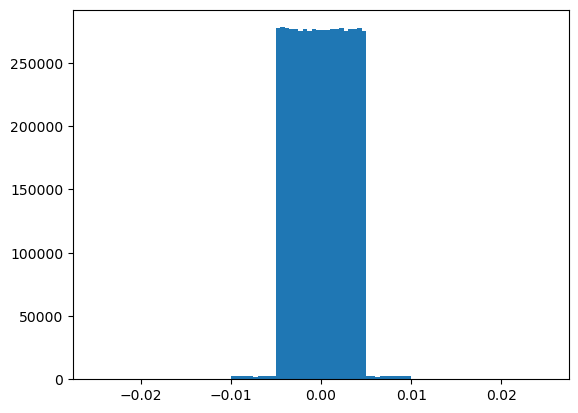

In [49]:
plt.hist(temp['Mr']-temp['MrAssigned'], bins=100, range=[-0.025, 0.025]);
print(max(temp['Mr']-temp['MrAssigned']))
print(min(temp['Mr']-temp['MrAssigned']))

(7.0, -4.0)

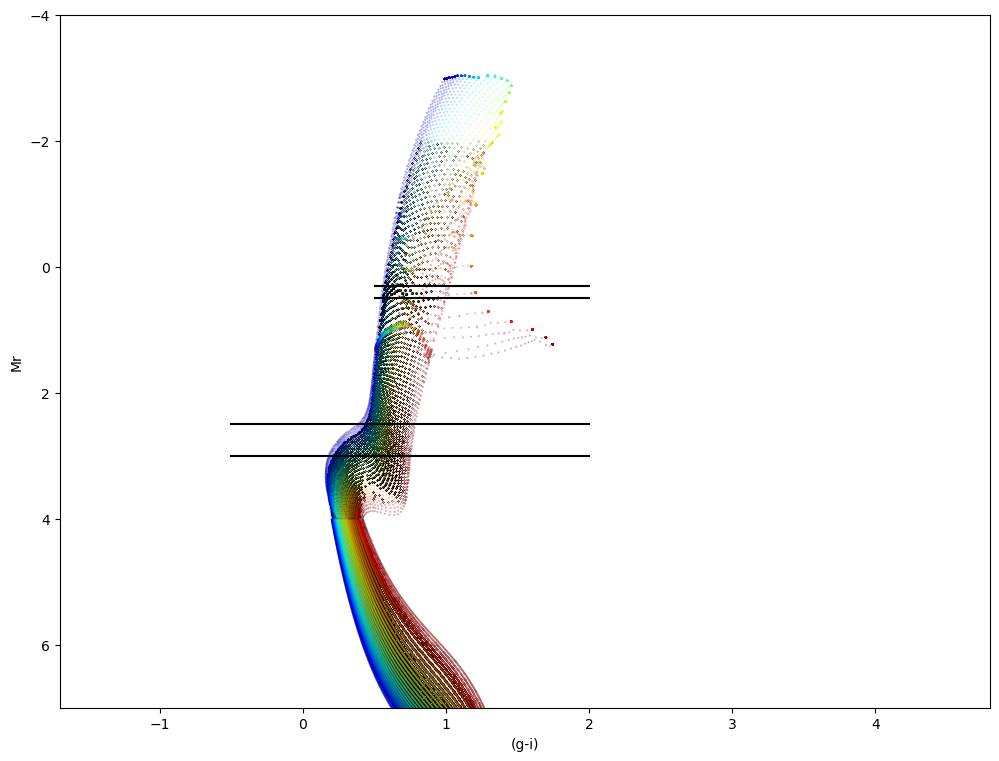

In [42]:
# compare selected stars to the full sample
fig,ax = plt.subplots(1,1,figsize=(12,9))

ax.set_xlim(-1.7,4.8)
ax.set_ylim(18,-4) 
ax.set_xlabel('(g-i)')
ax.set_ylabel('Mr')

ax.scatter(temp['gr'], temp['MrAssigned'], s=0.01, c='black')  
 
ax.scatter(L10['gr'], L10['Mr'], s=0.3, c=L10['FeH'], cmap=plt.cm.jet, alpha=0.3)

ax.plot(HWD['gr'], HWD['Mr'], 'r')
ax.plot(HeWD['gr'], HeWD['Mr'], 'b')


ax.plot([0.5, 2.0], [0.3,0.3], c='black')
ax.plot([0.5, 2.0], [0.5,0.5], c='black')

ax.plot([-0.5, 2.0], [3.0, 3.0], c='black')
ax.plot([-0.5, 2.0], [2.5,2.5], c='black')

ax.set_xlim(-1.7,4.8)
ax.set_ylim(7,-4) 


In [43]:
## assign colors to MSRG subsample
timeStart = !date +%s  
## actual call to get (dust-free) colors for each star in tGoodOK (5ms with fast version)
lt.getColorsFromMrFeHDSED(L10, tGoodMSRG)
timeEnd = !date +%s  
runTime = int(timeEnd[0])-int(timeStart[0])
print('Finished in', runTime, 'seconds.')

TypeError: 'Catalog' object does not support item assignment

In [22]:
MrChange = tGoodMSRG['Mr'] - tGoodMSRG['MrAssigned'] 
print(np.min(MrChange), np.median(MrChange), np.max(MrChange))

KeyError: 'MrAssigned'

In [19]:
MrChange = tGoodMSRG['Mr'] - tGoodMSRG['MrAssigned'] 
print(np.min(MrChange), np.median(MrChange), np.max(MrChange))

-0.04000000000000001 0.0 0.040000000000000036


In [18]:
sys.path.append('../src')
import LocusTools as lt
import PlotTools as pt
import importlib
importlib.reload(lt)
importlib.reload(pt)

fHe = 0.2    ## 0.1 in LSST Science Book, section 6.11.6 but we need to emphasize He more


def func2(df): #, pix):
    
    sys.path.append('../src')
    import LocusTools as lt
    import PlotTools as pt
    import importlib
    importlib.reload(lt)
    importlib.reload(pt)
    
    # return lt.getColorsFromMrFeHDSED(L10[['Mr', 'FeH', 'ug', 'gr', 'ri', 'iz']], df[['Mr', 'FeH', 'ug', 'gr', 'ri', 'iz']])
    return lt.getWDcolorsFromMr(HWD, HeWD, fHe, df) #(L10[::100], df.sample(frac=0.01))

# tGoodMSRG = catMSRG[(catMSRG['FeH']>=FeHmin)&(catMSRG['FeH']<=FeHmax)&(catMSRG['Mr']>MrRGcut)&(catMSRG['Mr']<MrMax)]

catWD_assigned_colors = catWD.map_partitions(func2) #, include_pixel=True).compute()

In [19]:
catWD_assigned_colors.compute()

2024-05-23 17:08:47,115 - distributed.worker - WARNING - Compute Failed
Key:       ('func2-110bc466d2086becab6189e35f198e55', 96)
Function:  subgraph_callable-6bc8d0ee284d77de4b203c874da38a03
args:      ('getitem-58f17ce7753b4e945e2277b3bbf1d61c', 9, 'label', {'number': 96, 'division': 8533476868936957952}, 'read_parquet_file_to_pandas-3722a8f2665cc56256086edb23060ff3', '/home/lovro/scratch/data/TRILEGAL_hipscat_new_2/trilegal/Norder=6/Dir=30000/Npix=30317.parquet')
kwargs:    {}
Exception: "ValueError('operands could not be broadcast together with shapes (611,) (301,) (301,) ')"

2024-05-23 17:08:47,201 - distributed.worker - WARNING - Compute Failed
Key:       ('func2-110bc466d2086becab6189e35f198e55', 93)
Function:  subgraph_callable-6bc8d0ee284d77de4b203c874da38a03
args:      ('getitem-58f17ce7753b4e945e2277b3bbf1d61c', 9, 'label', {'number': 93, 'division': 8532632444006825984}, 'read_parquet_file_to_pandas-3722a8f2665cc56256086edb23060ff3', '/home/lovro/scratch/data/TRILEGAL_hips

ValueError: operands could not be broadcast together with shapes (611,) (301,) (301,) 

2024-05-23 17:08:47,759 - distributed.worker - WARNING - Compute Failed
Key:       ('func2-110bc466d2086becab6189e35f198e55', 94)
Function:  subgraph_callable-6bc8d0ee284d77de4b203c874da38a03
args:      ('getitem-58f17ce7753b4e945e2277b3bbf1d61c', 9, 'label', {'number': 94, 'division': 8532913918983536640}, 'read_parquet_file_to_pandas-3722a8f2665cc56256086edb23060ff3', '/home/lovro/scratch/data/TRILEGAL_hipscat_new_2/trilegal/Norder=6/Dir=30000/Npix=30315.parquet')
kwargs:    {}
Exception: "ValueError('operands could not be broadcast together with shapes (6332,) (301,) (301,) ')"

2024-05-23 17:08:47,780 - distributed.worker - WARNING - Compute Failed
Key:       ('func2-110bc466d2086becab6189e35f198e55', 80)
Function:  subgraph_callable-6bc8d0ee284d77de4b203c874da38a03
args:      ('getitem-58f17ce7753b4e945e2277b3bbf1d61c', 9, 'label', {'number': 80, 'division': 8528973269309587456}, 'read_parquet_file_to_pandas-3722a8f2665cc56256086edb23060ff3', '/home/lovro/scratch/data/TRILEGAL_hip

In [20]:
## assign colors to WD subsample
fHe = 0.2    ## 0.1 in LSST Science Book, section 6.11.6 but we need to emphasize He more
lt.getWDcolorsFromMr(HWD, HeWD, fHe, catWD)

In [21]:
## merge MSRG and WD catalogs 
tGoodOK =  vstack([tGoodMSRG, catWD])  

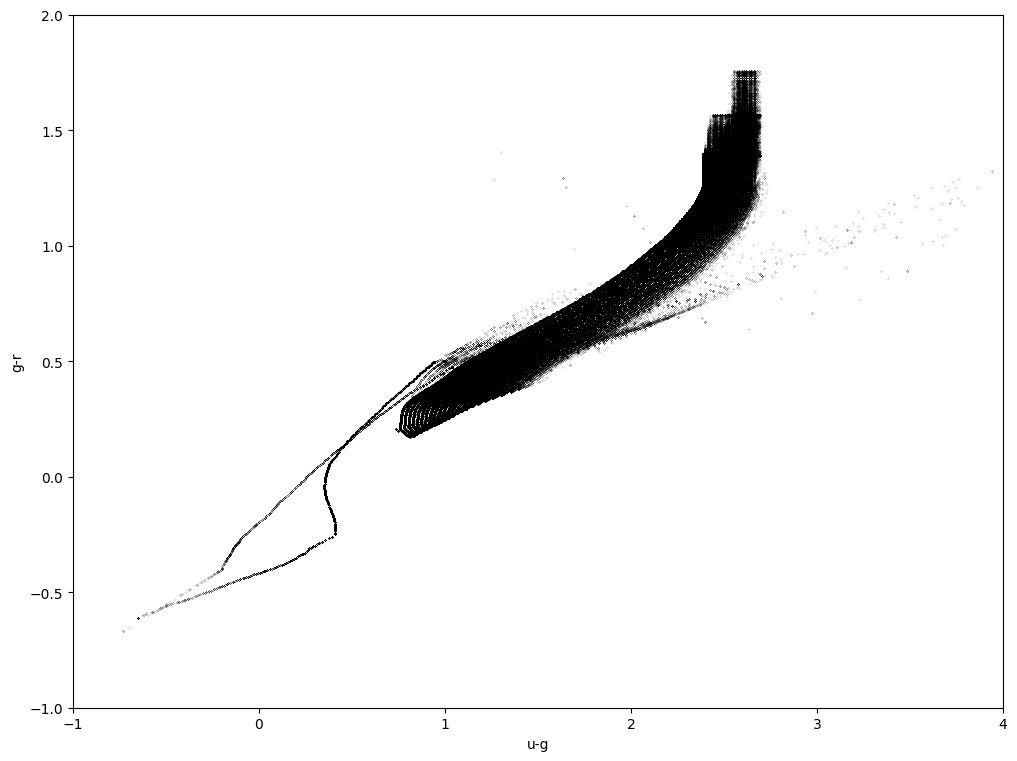

In [22]:
# compare selected stars to the full sample
fig,ax = plt.subplots(1,1,figsize=(12,9))

ax.set_xlim(-1.0,4.0)
ax.set_ylim(-1,2.0) 
ax.set_xlabel('u-g')
ax.set_ylabel('g-r')

ax.scatter(tGoodOK['ug'], tGoodOK['gr'], s=0.01, c='black')  

In [23]:
# let's rename them (and suffix 0 since they don't have dust reddening) 
tGoodOK['ugSL0'] = tGoodOK['ug']
tGoodOK['grSL0'] = tGoodOK['gr']
tGoodOK['riSL0'] = tGoodOK['ri']
tGoodOK['izSL0'] = tGoodOK['iz'] 
tGoodOK['giSL0'] = tGoodOK['grSL0'] + tGoodOK['riSL0']

In [24]:
## tGoodOK['ug0'] etc. are dust-free colors, now add reddening using Ar along the sightline from TRILEGAL 
## and standard extinction coefficients (from Berry+2012)
# first setup of dust extinction in each band
C = lt.extcoeff()
for b in ['u', 'g', 'i', 'z']:  
    tGoodOK['A'+b] = C[b]*tGoodOK['Ar']  
# and now redden input colors (from stellar locus)
tGoodOK['ugSL'] = tGoodOK['ugSL0'] + tGoodOK['Au'] - tGoodOK['Ag'] 
tGoodOK['grSL'] = tGoodOK['grSL0'] + tGoodOK['Ag'] - tGoodOK['Ar'] 
tGoodOK['riSL'] = tGoodOK['riSL0'] + tGoodOK['Ar'] - tGoodOK['Ai'] 
tGoodOK['izSL'] = tGoodOK['izSL0'] + tGoodOK['Ai'] - tGoodOK['Az'] 

In [27]:
# LSST-motivated faint limit for the output catalog (removes faint stars, ~28%)
rmagMax = 26.0 
giMin = -1.0
giMax = 5.0
tGood4sims = tGoodOK[(tGoodOK['giSL0']>giMin)&(tGoodOK['giSL0']<giMax)&(tGoodOK['ugSL0']>-1)&(tGoodOK['rmagTL']<rmagMax)]
print(np.size(tGood4sims), np.size(tGood4sims)/np.size(tGoodOK))

619576 0.6673114578239806


In [28]:
## 3) simulated (noise-free) magnitudes, anchored to TRILEGAL's original r band magnitude: tGood4sims['rmag']
#      note that colors 0 (e.g. tGood4sims['gr']) are DUST-FREE COLORS generated in lt.getColorsFromMrFeH,
#      while colors/magnitudes without "0" include dust reddening
#      tGood4sims['rmag'] comes directly from TRILEGAL (and it includes dust extinction) 
# other magnitudes with ISM extinction accounted for
tGood4sims['rmagSL'] = tGood4sims['rmagTL']
tGood4sims['gmagSL'] = tGood4sims['rmagSL'] + tGood4sims['grSL']
tGood4sims['umagSL'] = tGood4sims['gmagSL'] + tGood4sims['ugSL']
tGood4sims['imagSL'] = tGood4sims['rmagSL'] - tGood4sims['riSL']
tGood4sims['zmagSL'] = tGood4sims['imagSL'] - tGood4sims['izSL']

In [29]:
## 4) generate errors expected for LSST coadded depth (per Bianco+2022 paper)
#        note: errors are generated using true dust-extincted magnitudes generated in 3
errorsTrue = lt.getLSSTm5(tGood4sims, depth='coadd', magVersion=True, suffix='SL')

In [30]:
## 5) generate observed mags (by drawing random gaussian noise with mag-dependent std)
ObsMag = {}
for b in ['u', 'g', 'r', 'i', 'z']:  
    tGood4sims[b+'magErrSL'] = errorsTrue[b]
    noise = np.random.normal(0, tGood4sims[b+'magErrSL'])   
    ### this is a hack to prevent super faint stars ending up very bright ###
    minErr = np.where(np.abs(noise)>1, 1, noise)
    # adding noise to true noise-free dust-extincted magnitudes
    tGood4sims[b+'magObs'] = tGood4sims[b+'magSL'] + minErr
    ObsMag[b] = tGood4sims[b+'magObs'] 

In [31]:
# errors for "SL" colors
tGood4sims['ugErrSL'] = np.sqrt(tGood4sims['umagErrSL']**2 + tGood4sims['gmagErrSL']**2)
tGood4sims['grErrSL'] = np.sqrt(tGood4sims['gmagErrSL']**2 + tGood4sims['rmagErrSL']**2)
tGood4sims['riErrSL'] = np.sqrt(tGood4sims['rmagErrSL']**2 + tGood4sims['imagErrSL']**2)
tGood4sims['izErrSL'] = np.sqrt(tGood4sims['imagErrSL']**2 + tGood4sims['zmagErrSL']**2)

In [32]:
# now get errors derived from "observed" magnitudes
#   IMPORTANT: errors are NOT generated using original noise-free magnitudes
ObsMagErr = lt.getLSSTm5err(ObsMag)
for b in ['u', 'g', 'r', 'i', 'z']:  
    tGood4sims[b+'magErrObs'] = ObsMagErr[b]  

In [33]:
# test chi2 behavior for observed magnitudes
for b in ['u', 'g', 'r', 'i', 'z']:   
    chi = (tGood4sims[b+'magObs'] - tGood4sims[b+'magSL'])/tGood4sims[b+'magErrSL'] 
    chiB = chi[ObsMag[b] < 20]
    print('   band:', b, 'chi2dof=', np.std(chiB), np.std(chi))
    chi = (tGood4sims[b+'magObs'] - tGood4sims[b+'magSL'])/tGood4sims[b+'magErrObs']  
    chiB = chi[ObsMag[b] < 20]
    print('trueErr:', b, 'chi2dof=', np.std(chiB), np.std(chi))

   band: u chi2dof= 0.9982733939608999 0.7389055639437017
trueErr: u chi2dof= 0.9982691810534476 0.7927063032842744
   band: g chi2dof= 1.0086654748793498 1.0002131695607612
trueErr: g chi2dof= 1.0086670761863306 1.0326817269880422
   band: r chi2dof= 0.9982349529506308 0.9998378566636895
trueErr: r chi2dof= 0.9982369754766585 1.0023863691903583
   band: i chi2dof= 1.0031877927342117 1.0020646040535028
trueErr: i chi2dof= 1.0031892554908648 1.0043989703195446
   band: z chi2dof= 0.9982837749929174 0.9992428284485949
trueErr: z chi2dof= 0.9982880382602034 1.005212719776287


In [34]:
chi2 = 0*ObsMagErr['u']
for b in ['u', 'g', 'r', 'i', 'z']:   
    chi2 = chi2 + ((tGood4sims[b+'magObs'] - tGood4sims[b+'magSL'])/tGood4sims[b+'magErrSL'])**2 
chi2B = chi2[ObsMag['u']<20]
print('  mean, median:', np.mean(chi2)/5, np.median(chi2)/5)
print('B mean, median:', np.mean(chi2B)/5, np.median(chi2B)/5)

  mean, median: 0.9132521138249382 0.7847536657015327
B mean, median: 1.000701423353925 0.8727170613174872


In [35]:
# generate observed colors (with and without dust extinction)
tGood4sims['ugObs'] = tGood4sims['umagObs'] - tGood4sims['gmagObs'] 
tGood4sims['grObs'] = tGood4sims['gmagObs'] - tGood4sims['rmagObs'] 
tGood4sims['riObs'] = tGood4sims['rmagObs'] - tGood4sims['imagObs'] 
tGood4sims['izObs'] = tGood4sims['imagObs'] - tGood4sims['zmagObs'] 
tGood4sims['giObs'] = tGood4sims['grObs'] + tGood4sims['riObs'] 

# correct colors for ISM dust reddening
tGood4sims['ugObs0'] = tGood4sims['ugObs'] - (tGood4sims['Au']-tGood4sims['Ag'])
tGood4sims['grObs0'] = tGood4sims['grObs'] - (tGood4sims['Ag']-tGood4sims['Ar'])
tGood4sims['riObs0'] = tGood4sims['riObs'] - (tGood4sims['Ar']-tGood4sims['Ai'])
tGood4sims['izObs0'] = tGood4sims['izObs'] - (tGood4sims['Ai']-tGood4sims['Az'])
tGood4sims['giObs0'] = tGood4sims['giObs'] - (tGood4sims['Ag']-tGood4sims['Ai'])

# errors for observed colors 
tGood4sims['ugErrObs'] = np.sqrt(tGood4sims['umagErrObs']**2 + tGood4sims['gmagErrObs']**2) 
tGood4sims['grErrObs'] = np.sqrt(tGood4sims['gmagErrObs']**2 + tGood4sims['rmagErrObs']**2) 
tGood4sims['riErrObs'] = np.sqrt(tGood4sims['rmagErrObs']**2 + tGood4sims['imagErrObs']**2) 
tGood4sims['izErrObs'] = np.sqrt(tGood4sims['imagErrObs']**2 + tGood4sims['zmagErrObs']**2) 

In [36]:
## test chi2 for observed colors
colors = ('ug', 'gr', 'ri', 'iz')  
for c in colors:
    dm = (tGood4sims[c+'Obs']-tGood4sims[c+'SL']) 
    chiT = dm / tGood4sims[c+'ErrSL']  
    chiO = dm / tGood4sims[c+'ErrObs']   
    print(c, np.mean(dm), np.std(dm), np.mean(chiT), np.std(chiT), np.mean(chiO), np.std(chiO))

ug 0.3563442783868218 0.5694330004602948 0.1322574895565222 0.7400088600715612 -0.04587240308184983 0.7906354558620554
gr -0.00013108072405583615 0.12328475843273147 -0.0009713187328106588 1.0001454883139267 -0.0597382452637355 1.0221224432118456
ri -4.188755846178621e-05 0.04879660769336645 -0.0017533919368945526 1.001178843277304 -0.004968413129164027 1.0010178568133685
iz 5.534424192116613e-05 0.06092153293999032 0.0007340211709933959 1.0002707120819805 0.011872276677898502 1.0006049805007262


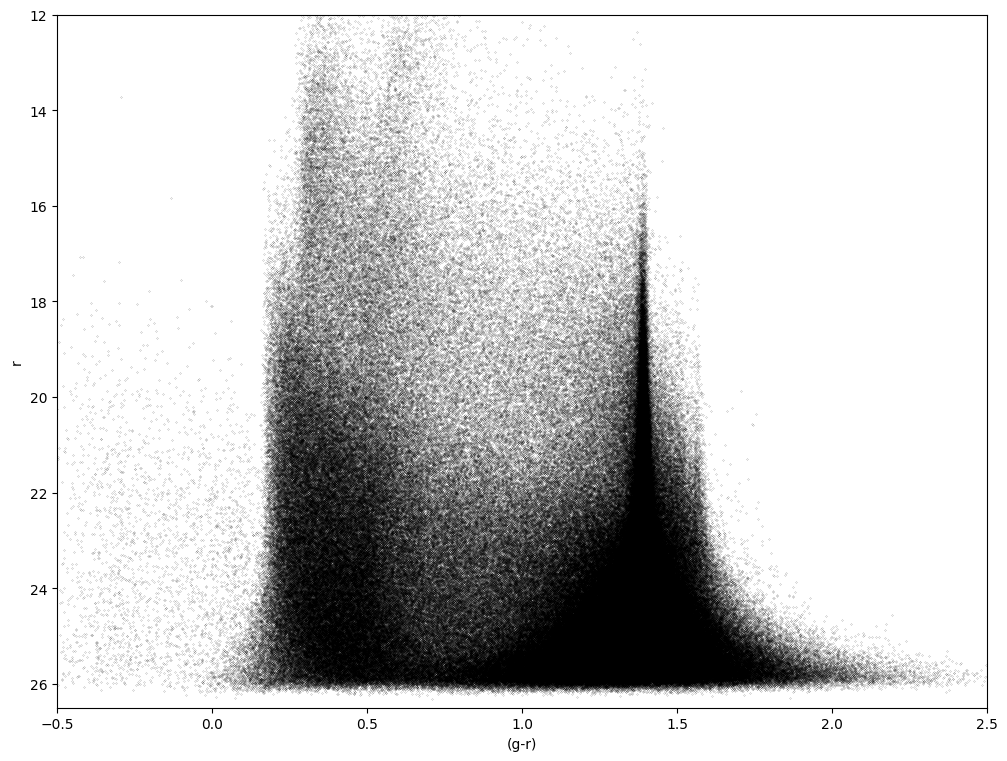

In [37]:
## last test before making output file...
fig,ax = plt.subplots(1,1,figsize=(12,9))

ax.set_xlim(-0.5,2.5)
ax.set_ylim(26.5,12)

ax.set_xlabel('(g-r)')
ax.set_ylabel('r')

ax.scatter(tGood4sims['grObs0'], tGood4sims['rmagObs'], s=0.01, c='black')  

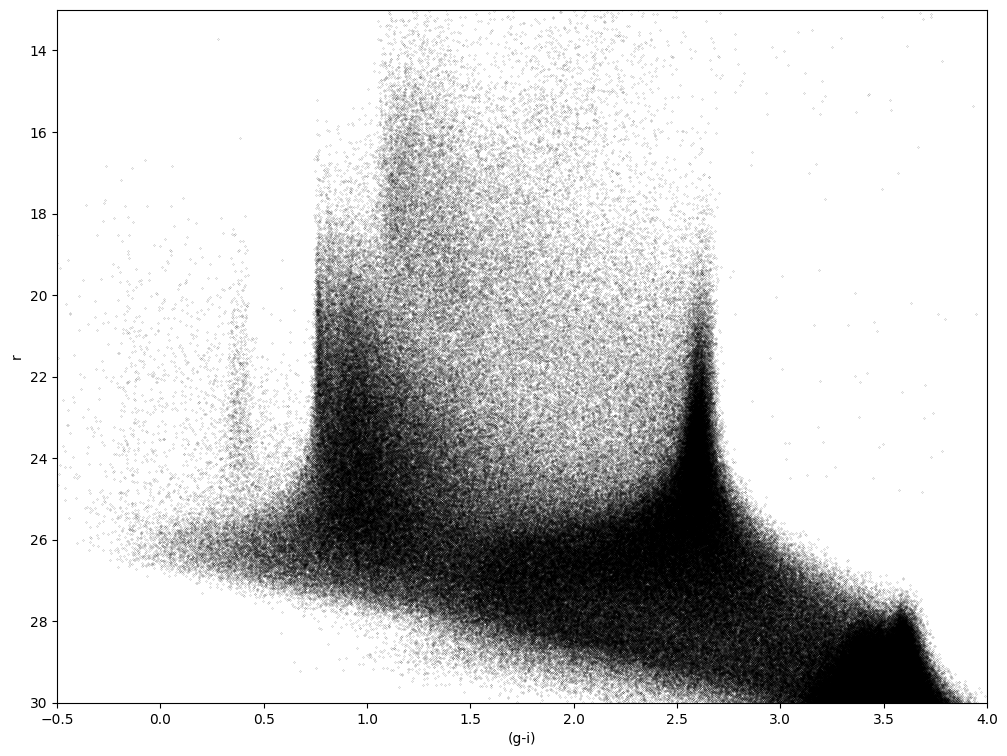

In [38]:
## last test before making output file...
fig,ax = plt.subplots(1,1,figsize=(12,9))

ax.set_xlim(-0.5,4.0)
ax.set_ylim(30,13) 

ax.set_xlabel('(g-i)')
ax.set_ylabel('r')

ax.scatter(tGood4sims['ugObs0'], tGood4sims['umagObs'], s=0.01, c='black')  

In [39]:
tGood4simsBu = tGood4sims[tGood4sims['umagObs']<25]
print(len(tGood4sims), len(tGood4simsBu))

619576 139355


In [ ]:
## last test before making output file...
fig,ax = plt.subplots(1,1,figsize=(12,9))

ax.set_xlim(-2.0,5)
ax.set_ylim(18,-4) 

ax.set_xlabel('(g-i)')
ax.set_ylabel('Mr')

ax.scatter(tGood4sims['giObs0'], tGood4sims['Mr'], s=0.01, c='black')  
#ax.scatter(tGood4simsBu['giObs0'], tGood4simsBu['Mr'], s=0.01, c='blue')  


ax.plot([0.5, 2.0], [0.3,0.3], c='red')
ax.plot([0.5, 2.0], [0.5,0.5], c='red')

 

ax.plot([-0.5, 2.0], [3.0, 3.0], c='black')
ax.plot([-0.5, 2.0], [2.5,2.5], c='black')
ax.plot([-0.5, 2.0], [3.5,3.5], c='black')

ax.plot([-0.5, 2.0], [6,6], c='cyan')

ax.plot([0.30, 0.30], [3.06, 4.15], c='cyan')
# ax.plot([0.30, 0.30], [3.06, 4.15], c='yellow')

ax.set_xlim(0,1.5)
ax.set_ylim(7.5, 1.5) 


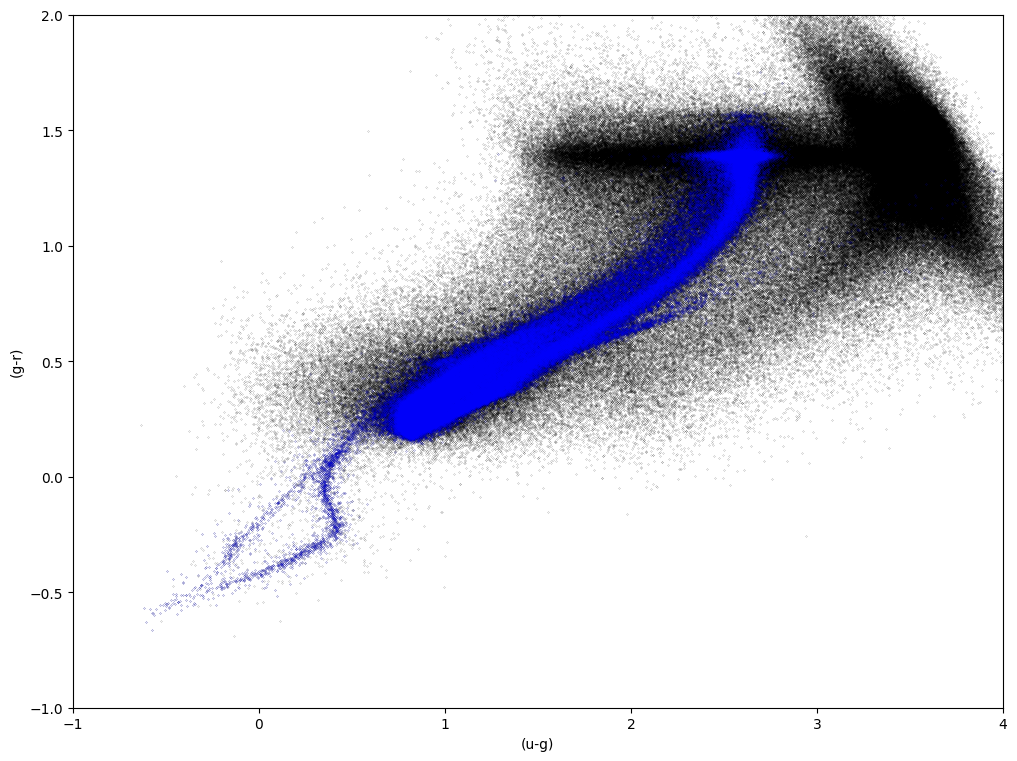

In [41]:
## last test before making output file...
fig,ax = plt.subplots(1,1,figsize=(12,9))
 
ax.set_xlim(-1.0,4.0)
ax.set_ylim(-1,2.0) 

ax.set_xlabel('(u-g)')
ax.set_ylabel('(g-r)')

ax.scatter(tGood4sims['ugObs0'], tGood4sims['grObs0'], s=0.01, c='black')  

ax.scatter(tGood4simsBu['ugObs0'], tGood4simsBu['grObs0'], s=0.01, c='blue')  

In [42]:
## 6) store in a data file  
outfile = '../data/AstroLabPriors/Stripe82/SDSSpatchRA340-350-simLSSTcatalog.txt'
fout = open(outfile, "w")
fout.write("      glon       glat      comp   logg    FeH      Mr      DM      Ar ")
fout.write(" rmagObs0   ug0     gr0     ri0     iz0    rmag   ugObs   grObs   riObs   izObs")
fout.write("   uErr   gErr   rErr   iErr   zErr    ugSL    grSL    riSL    izSL")
fout.write(" ugErrSL grErrSL riErrSL izErrSL \n")
for i in range(0,np.size(tGood4sims)):
    # input values from TRILEGAL
    r1 = tGood4sims['glon'][i]
    r2 = tGood4sims['glat'][i]
    r3 = tGood4sims['GC'][i]
    r4 = tGood4sims['logg'][i]
    r5 = tGood4sims['FeH'][i]
    r6 = tGood4sims['Mr'][i]
    r7 = tGood4sims['DM'][i]
    r8 = tGood4sims['Ar'][i]  
    s = str("%12.8f " % r1) + str("%12.8f  " % r2) + str("%3.0f  " % r3) + str("%6.2f  " % r4)
    s = s + str("%5.2f  " % r5) + str("%6.2f  " % r6) + str("%6.2f  " % r7) + str("%6.3f  " % r8)  
    # observed colors, corrected for ISM extinction, same errors as for ugObs... below
    r1 = tGood4sims['rmagTL'][i]
    r2 = tGood4sims['ugObs0'][i] 
    r3 = tGood4sims['grObs0'][i] 
    r4 = tGood4sims['riObs0'][i] 
    r5 = tGood4sims['izObs0'][i] 
    s = s + str("%6.2f" % r1) + str("%8.3f" % r2) + str("%8.3f" % r3) + str("%8.3f" % r4) + str("%8.3f" % r5)
    # observed colors, with ISM extinction included
    r1 = tGood4sims['rmagObs'][i]
    r2 = tGood4sims['ugObs'][i] 
    r3 = tGood4sims['grObs'][i] 
    r4 = tGood4sims['riObs'][i] 
    r5 = tGood4sims['izObs'][i] 
    s = s + str("%8.2f" % r1) + str("%8.3f" % r2) + str("%8.3f" % r3) + str("%8.3f" % r4) + str("%8.3f" % r5)
    # errors for observed mags, generated from observed mags
    r1 = tGood4sims['umagErrObs'][i]
    r2 = tGood4sims['gmagErrObs'][i]
    r3 = tGood4sims['rmagErrObs'][i]
    r4 = tGood4sims['imagErrObs'][i]
    r5 = tGood4sims['zmagErrObs'][i]
    s = s + str("%7.3f" % r1) + str("%7.3f" % r2) + str("%7.3f" % r3) + str("%7.3f" % r4) + str("%7.3f" % r5)
    # true input values (ISM extinction included)
    r2 = tGood4sims['ugSL'][i] 
    r3 = tGood4sims['grSL'][i] 
    r4 = tGood4sims['riSL'][i] 
    r5 = tGood4sims['izSL'][i] 
    s = s + str("%8.3f" % r2) + str("%8.3f" % r3) + str("%8.3f" % r4) + str("%8.3f" % r5)
    # true errors based on input mag values above
    r2 = tGood4sims['ugErrSL'][i] 
    r3 = tGood4sims['grErrSL'][i] 
    r4 = tGood4sims['riErrSL'][i] 
    r5 = tGood4sims['izErrSL'][i] 
    s = s + str("%8.3f" % r2) + str("%8.3f" % r3) + str("%8.3f" % r4) + str("%8.3f" % r5)
    s = s + "\n"
    fout.write(s)             
fout.close() 

In [43]:
np.max(tGoodMSRG['Mr'])

15.99

In [44]:
L10

tLoc,Mr,FeH,ug,gr,ri,iz,gi
float64,float64,float64,float64,float64,float64,float64,float64
1.4,-2.98,-2.5,1.91,0.988,0.413,0.23,1.401
1.41,-2.98,-2.5,1.91,0.988,0.413,0.23,1.401
1.42,-2.98,-2.5,1.91,0.988,0.413,0.23,1.401
1.43,-2.98,-2.5,1.91,0.988,0.413,0.23,1.401
1.44,-2.98,-2.5,1.91,0.988,0.413,0.23,1.401
1.45,-2.98,-2.5,1.91,0.988,0.413,0.23,1.401
1.46,-2.98,-2.5,1.91,0.988,0.413,0.23,1.401
...,...,...,...,...,...,...,...
15.94,15.94,0.5,2.706,1.733,2.226,1.432,3.959
